In [1]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Could not find a version that satisfies the requirement tensorflow~=2.11.0 (from tensorflow-federated) (from versions: 0.12.0, 0.12.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.3.0, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.9.0, 1.10.0, 1.10.1, 1.11.0, 1.12.0, 1.12.2, 1.12.3, 1.13.1, 1.13.2, 1.14.0)
No matching distribution found for tensorflow~=2.11.0 (from tensorflow-federated)
Exception:
Traceback (most recent call last):
  File "/usr/lib/python2.7/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/lib/python2.7/site-packages/pip/commands/install.py", line 326, in run
    strip_file_prefix=options.strip_file_prefix,
  File "/usr/lib/python2.7/site-packages/pip/req/req_set.py", line 742, in install
    **kwargs
  File "/usr/lib/python2.7/site-packages/pip/req/req_ins

In [ ]:
from Pyfhel import Pyfhel, PyCtxt

In [2]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# Must use the Python context because it
# supports tff.sequence_* intrinsics.
executor_factory = tff.framework.local_executor_factory(
    support_sequence_ops=True)
execution_context = tff.framework.ExecutionContext(
    executor_fn=executor_factory)
tff.framework.set_default_context(execution_context)

2022-12-04 22:46:02.840403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 22:46:03.023751: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-04 22:46:03.079773: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 22:46:04.488388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
def HEmatmult(a, b):
    return np.matmul(a, b)

def HEreduce_mean(a, axis=None):
    if axis is None:
        return np.sum(a)/a.size
    return np.sum(a, axis=axis)/a.shape[axis]

def HEreduce_sum(a, axis=None):
    return np.sum(a, axis=axis)

def HEexp(a, n=4):
    d = 1.0
    rt = 0.0
    for i in range(n):
        rt += d/np.math.factorial(i)
        d = a*d
    return rt

def HEsquare(a):
    return a**2

In [3]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

2022-12-04 22:46:12.369683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-04 22:46:12.369730: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-04 22:46:12.370354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


b'Hello, World!'

In [4]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

In [ ]:
en1 = Pyfhel(context_params={'scheme':'ckks', 'n':2**14, 'scale':2**30, 'qi_sizes':[30]*5})
en1.keyGen()

In [6]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([en1.encrypt(source[0][i].flatten() / 255.0) for i in batch_samples],
                     dtype=PyCtxt),
        'y':
            np.array([en1.encrypt(source[1][i]) for i in batch_samples], dtype=PyCtxt)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

In [7]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

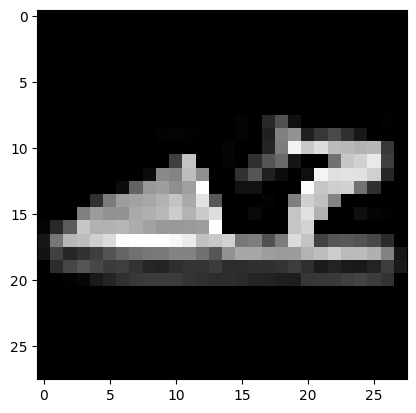

In [8]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

In [9]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

In [10]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)
print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


In [11]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = HEsquare(
      HEmatmult(batch['x'], model['weights']) + model['bias'])
  return -HEreduce_mean(
      HEreduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

In [12]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

In [13]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

In [14]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [15]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

In [16]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [17]:
losses

[0.39846364, 0.25261888, 0.19375294, 0.16018456, 0.1380317]

In [18]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  @tff.tf_computation(LOCAL_DATA_TYPE, tf.float32)
  def _insert_learning_rate_to_sequence(dataset, learning_rate):
    return dataset.map(lambda x: (x, learning_rate))

  batches_with_learning_rate = _insert_learning_rate_to_sequence(all_batches, learning_rate)

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, batches_with_learning_rate.type_signature.element)
  def batch_fn(model, batch_with_lr):
    batch, lr = batch_with_lr
    return batch_train(model, batch, lr)

  return tff.sequence_reduce(batches_with_learning_rate, initial_model, batch_fn)

In [19]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

In [20]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

In [21]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):

  @tff.tf_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
  def _insert_model_to_sequence(model, dataset):
    return dataset.map(lambda x: (model, x))

  model_plus_data = _insert_model_to_sequence(model, all_batches)

  @tff.tf_computation(tf.float32, batch_loss.type_signature.result)
  def tff_add(accumulator, arg):
    return accumulator + arg

  return tff.sequence_reduce(
      tff.sequence_map(
          batch_loss,
          model_plus_data), 0., tff_add)

In [22]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

In [23]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.8081478


In [24]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 79.414024


In [25]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

In [26]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model),  data]))

In [27]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 83.617744


In [28]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  # Perform federated averaging here
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

In [29]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=20.691389083862305
round 1, loss=19.161178588867188
round 2, loss=17.984769821166992
round 3, loss=17.064708709716797
round 4, loss=16.326141357421875


In [30]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 23.025852
trained_model test loss = 16.38777
